In [1]:
%matplotlib notebook
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from tabulate import tabulate
from sklearn.manifold import MDS
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn
import math
import os

from src.internal_library import *
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mateosarja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
N_INGREDIENTS = 500

recipes, ingredients, ratings = import_rated_recipes(N_INGREDIENTS)

edge_list, edge_matrix = build_edges(ingredients)

ingredient_list = np.sort(ingredients['ingredient'].unique())

print(f'recipes : {recipes.shape}')
print(f'ingredients : {ingredients.shape}')
print(f'ratings : {ratings.shape}')
print(f'ingredient_list : {ingredient_list.shape}')
print(f'edge_matrix : {edge_matrix.shape}')

/Users/mateosarja/Documents/Uni/Year 4/FYP/FYP/src/internal_library.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ingredients.drop_duplicates(inplace=True)


recipes : (194709, 492)
ingredients : (1346387, 3)
ratings : (102430, 2)
ingredient_list : (492,)
edge_matrix : (492, 492)


In [3]:
distance_matrix = get_feature_matrix(edge_matrix, 'log_distance')
pmi_matrix = get_feature_matrix(edge_matrix, 'PMI', recipes_per_ingredient=recipes.sum())
iou_matrix = get_feature_matrix(edge_matrix, 'IOU', recipes_per_ingredient=recipes.sum())
# mini = pmi_matrix[pmi_matrix>0].min().min()
# print(pmi_matrix[pmi_matrix>0].min().min())
# print(pmi_matrix[pmi_matrix>0].max().max())
# print(distance_matrix[distance_matrix>0].min().min())
# print(distance_matrix[distance_matrix>0].max().max())
# print(iou_matrix[iou_matrix>0].min().min())
# print(iou_matrix[iou_matrix>0].max().max())

# print(1/mini)

/Users/mateosarja/Documents/Uni/Year 4/FYP/FYP/src/internal_library.py:213: RuntimeWarning: divide by zero encountered in log
  feature_matrix.loc[x,y] = np.log(scale * pmi)     # Scale to keep all distances positive


<IPython.core.display.Javascript object>


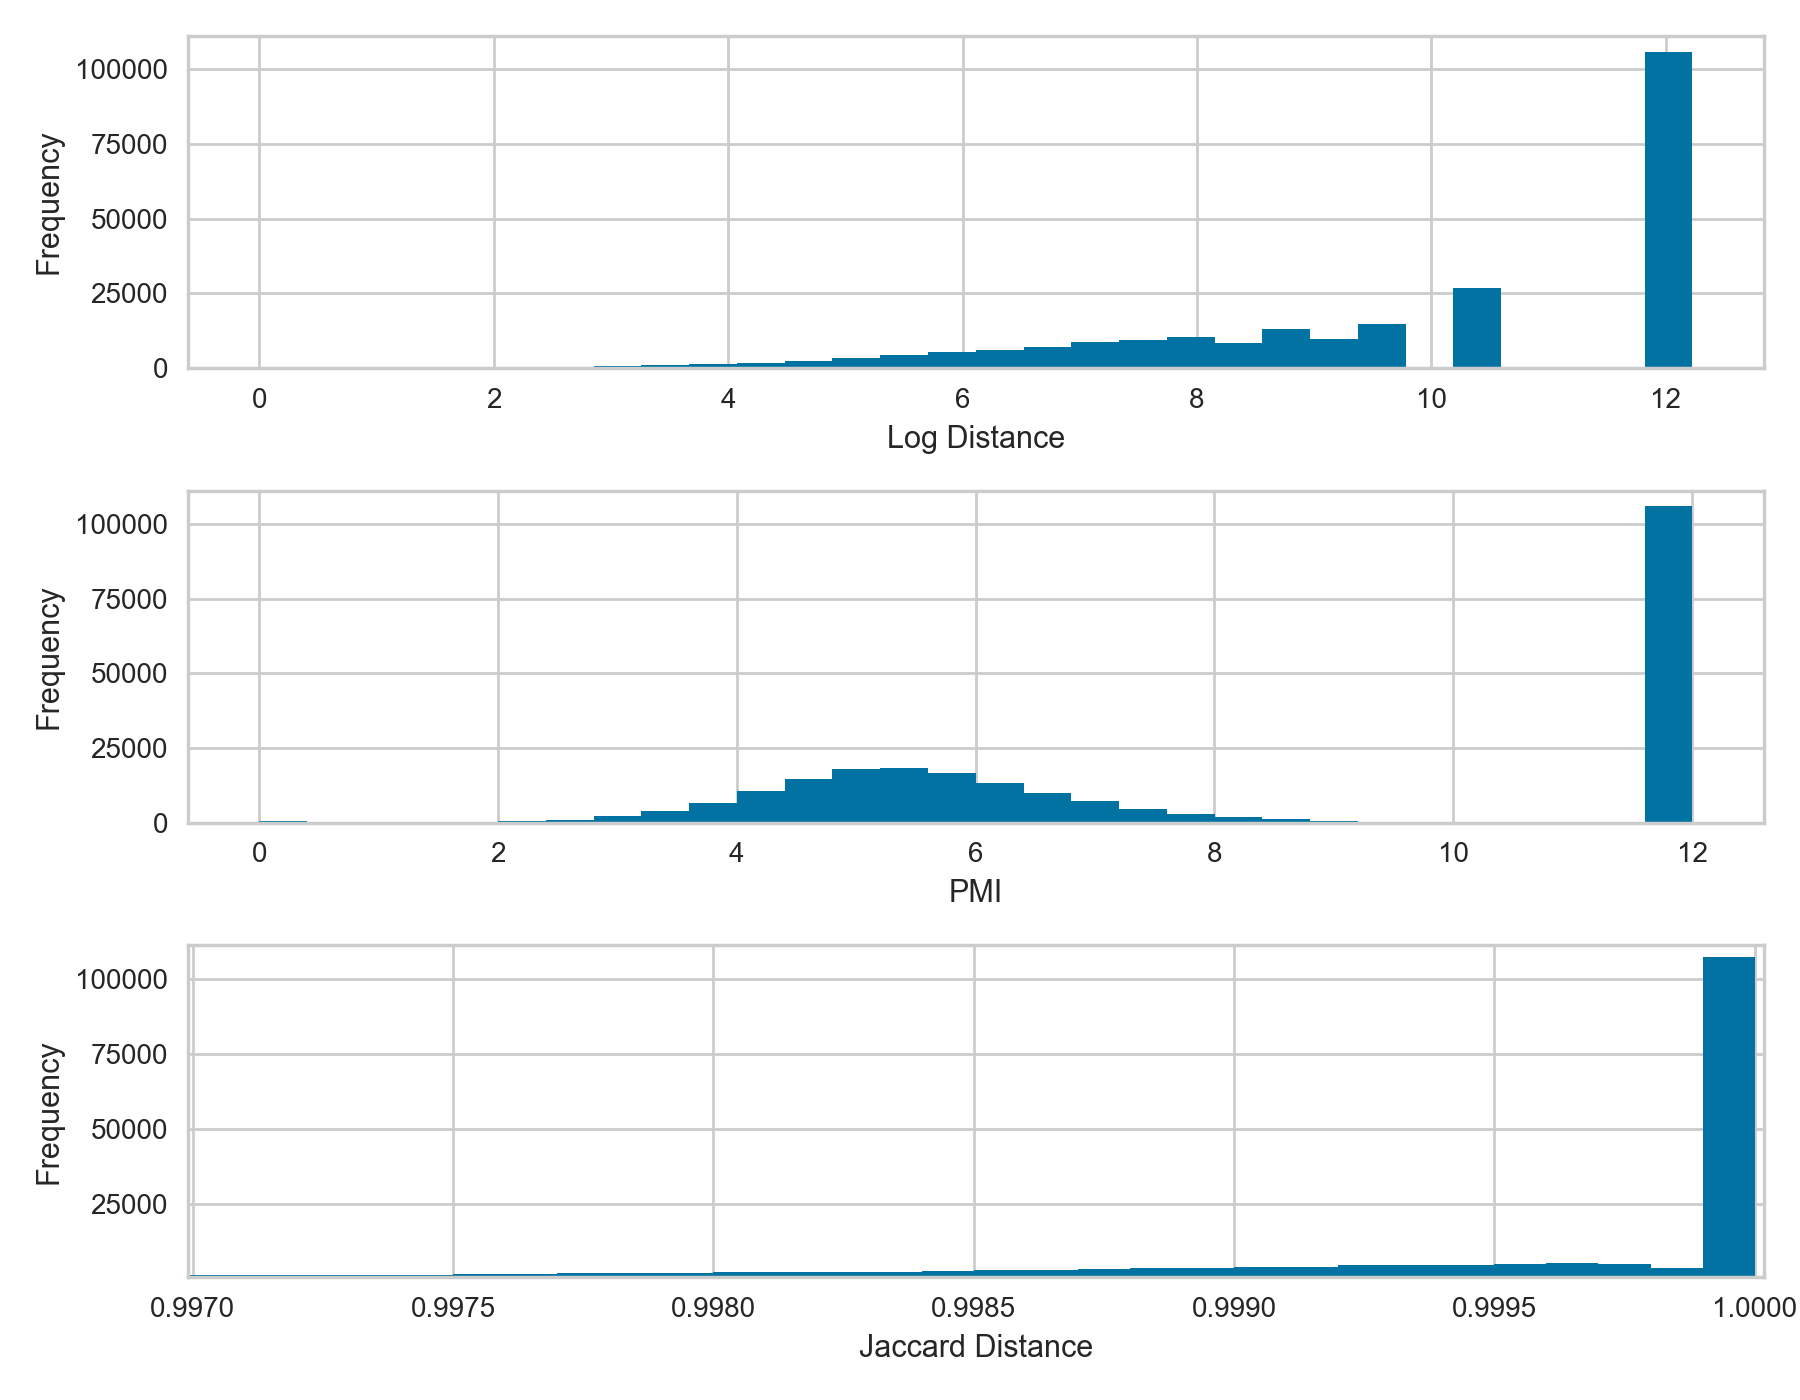

In [84]:
# print(distance_matrix.min().min())
# print(distance_matrix.max().max())
# print(pmi_matrix.min().min())
# print(pmi_matrix.max().max())
# print(iou_matrix.min().min())
# print(iou_matrix.max().max())

n_bins = 30

plt.figure(figsize=(9,7))
plt.subplot(311)
plt.hist(distance_matrix.values.flatten(), bins=n_bins)
# plt.title('Log Distance')
plt.xlabel('Log Distance')
plt.ylabel('Frequency')


plt.subplot(312)
plt.hist(pmi_matrix.values.flatten(), bins=n_bins)
plt.xlabel('PMI')
plt.ylabel('Frequency')

plt.subplot(313)
plt.hist(iou_matrix.values.flatten(), bins=10000)
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
distance_mds = mds(distance_matrix, 3)
pmi_mds = mds(pmi_matrix, 3)
iou_mds = mds(iou_matrix, 3)

In [13]:
lsa_out_df = cluster(lsa_out_df, 7, 'agg')
lsa_out_df['cluster'].to_csv('control_group/lsa_7.csv')
distance_mds = cluster(distance_mds, 8, 'agg')
distance_mds['cluster'].to_csv('control_group/distance_8.csv')
pmi_mds = cluster(pmi_mds, 7, 'agg')
pmi_mds['cluster'].to_csv('control_group/pmi_7.csv')
iou_mds = cluster(iou_mds, 7, 'agg')
iou_mds['cluster'].to_csv('control_group/iou_7.csv')
# distance_mds['cluster'].sort_values().to_csv('log_cluster_2dim')
# pmi_mds['cluster'].sort_values().to_csv('pmi_cluster_2dim')
# iou_mds['cluster'].sort_values().to_csv('iou_cluster_2dim')
# stacked = cluster(pd.concat([distance_mds, pmi_mds[0], iou_mds[0]], axis=1), 2, 'agg') 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.t

In [100]:
clusters = pd.read_csv('ing_list.csv', index_col=1)
print((clusters['cluster'] - distance_mds['cluster']).value_counts())
print((clusters['cluster'] - pmi_mds['cluster']).value_counts())
print((clusters['cluster'] - iou_mds['cluster']).value_counts())


 0    417
-1     51
 1     13
Name: cluster, dtype: int64
 0    424
-1     49
 1      8
Name: cluster, dtype: int64
 0    245
-1    133
 1    103
Name: cluster, dtype: int64


# LSA

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

X = recipes.sort_index()
print(X.shape)

lsa = TruncatedSVD(250, algorithm = 'arpack')
lsa_out = lsa.fit_transform(X.T)
lsa_out_df = pd.DataFrame(lsa_out)
lsa_out_df = pd.DataFrame(normalize(lsa_out_df))
lsa_out_df.index = ingredient_list

(194709, 492)


<IPython.core.display.Javascript object>


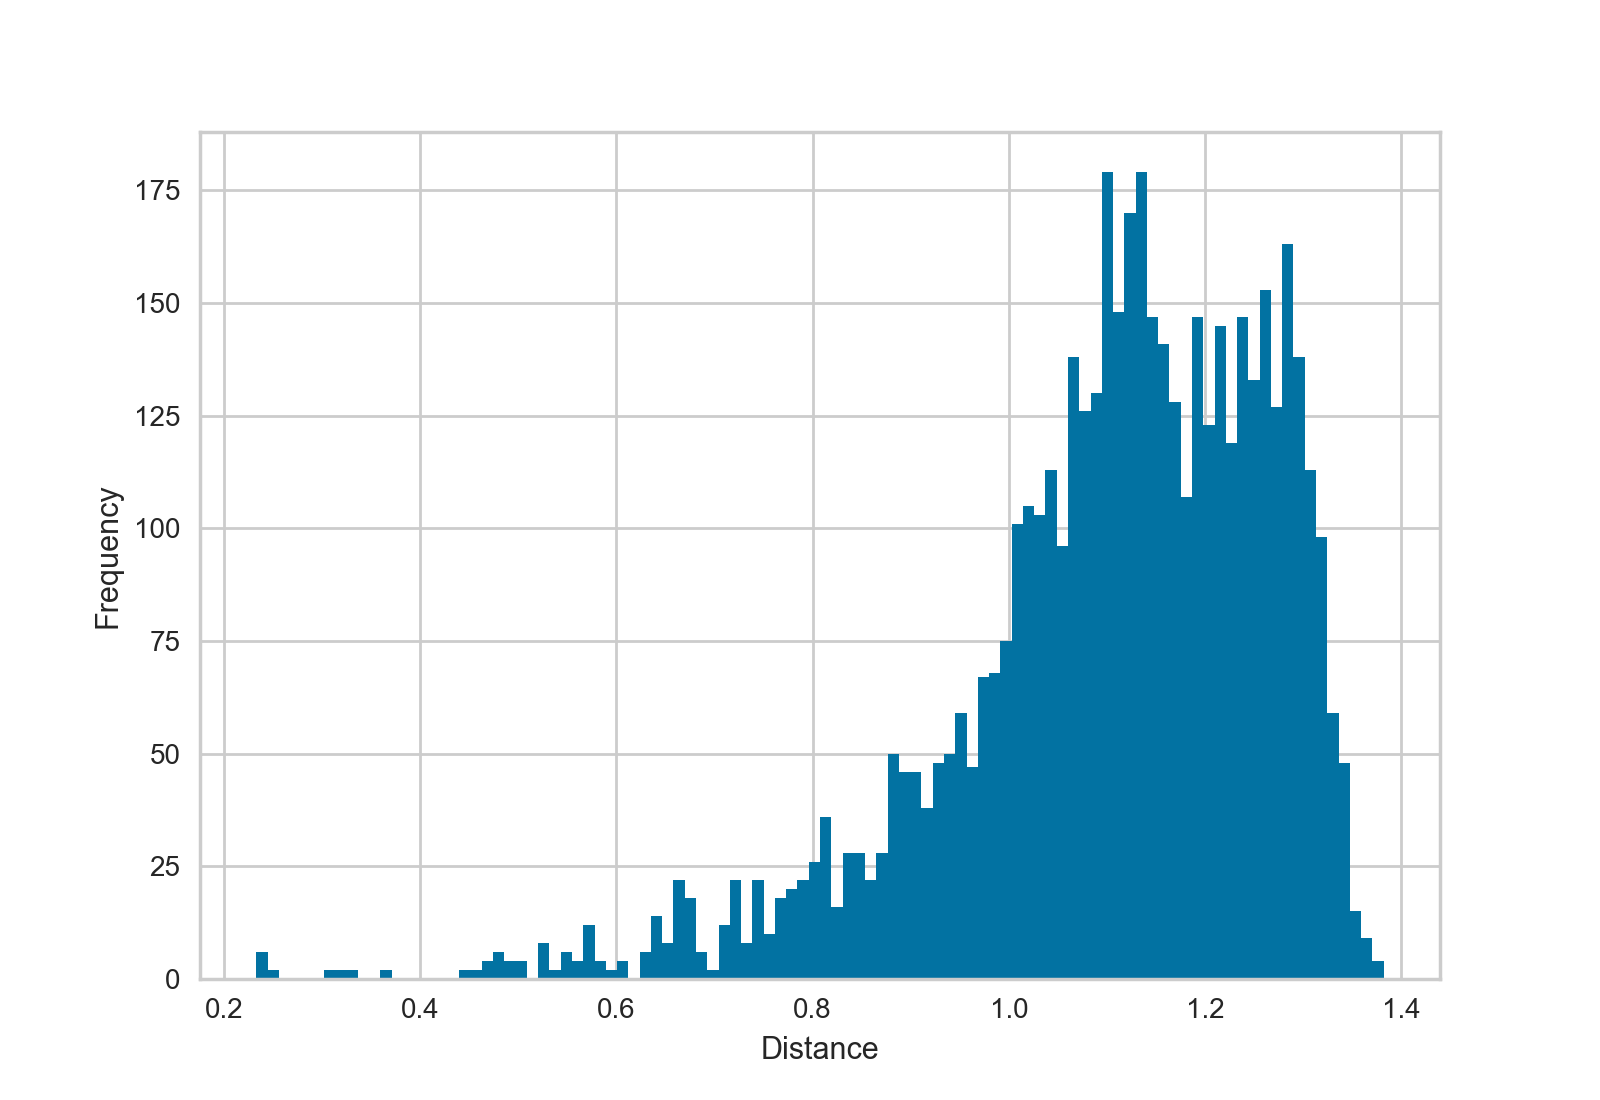

2952
1.102059201685176


In [135]:


lsa_out_df = pd.DataFrame(normalize(lsa_out_df))
lsa_out_df.index = ingredient_list

lsa_neighbors = get_neighbors(lsa_out_df, ingredient_list, plot=True)
flat = lsa_neighbors[['distance_1','distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7', 'distance_8', 'distance_9', 'distance_10']].values.flatten()
flat = np.sort(flat)
length = int(flat.shape[0] * 0.6)
print(length)
print(flat.mean())

In [108]:
lsa_neighbors = find_pairs(lsa_out_df, 1.1, edge_matrix, ingredient_list)
lsa_neighbors.to_csv('control_group/google/lsa_comp.csv')

Filtering...


# Pairing

<IPython.core.display.Javascript object>


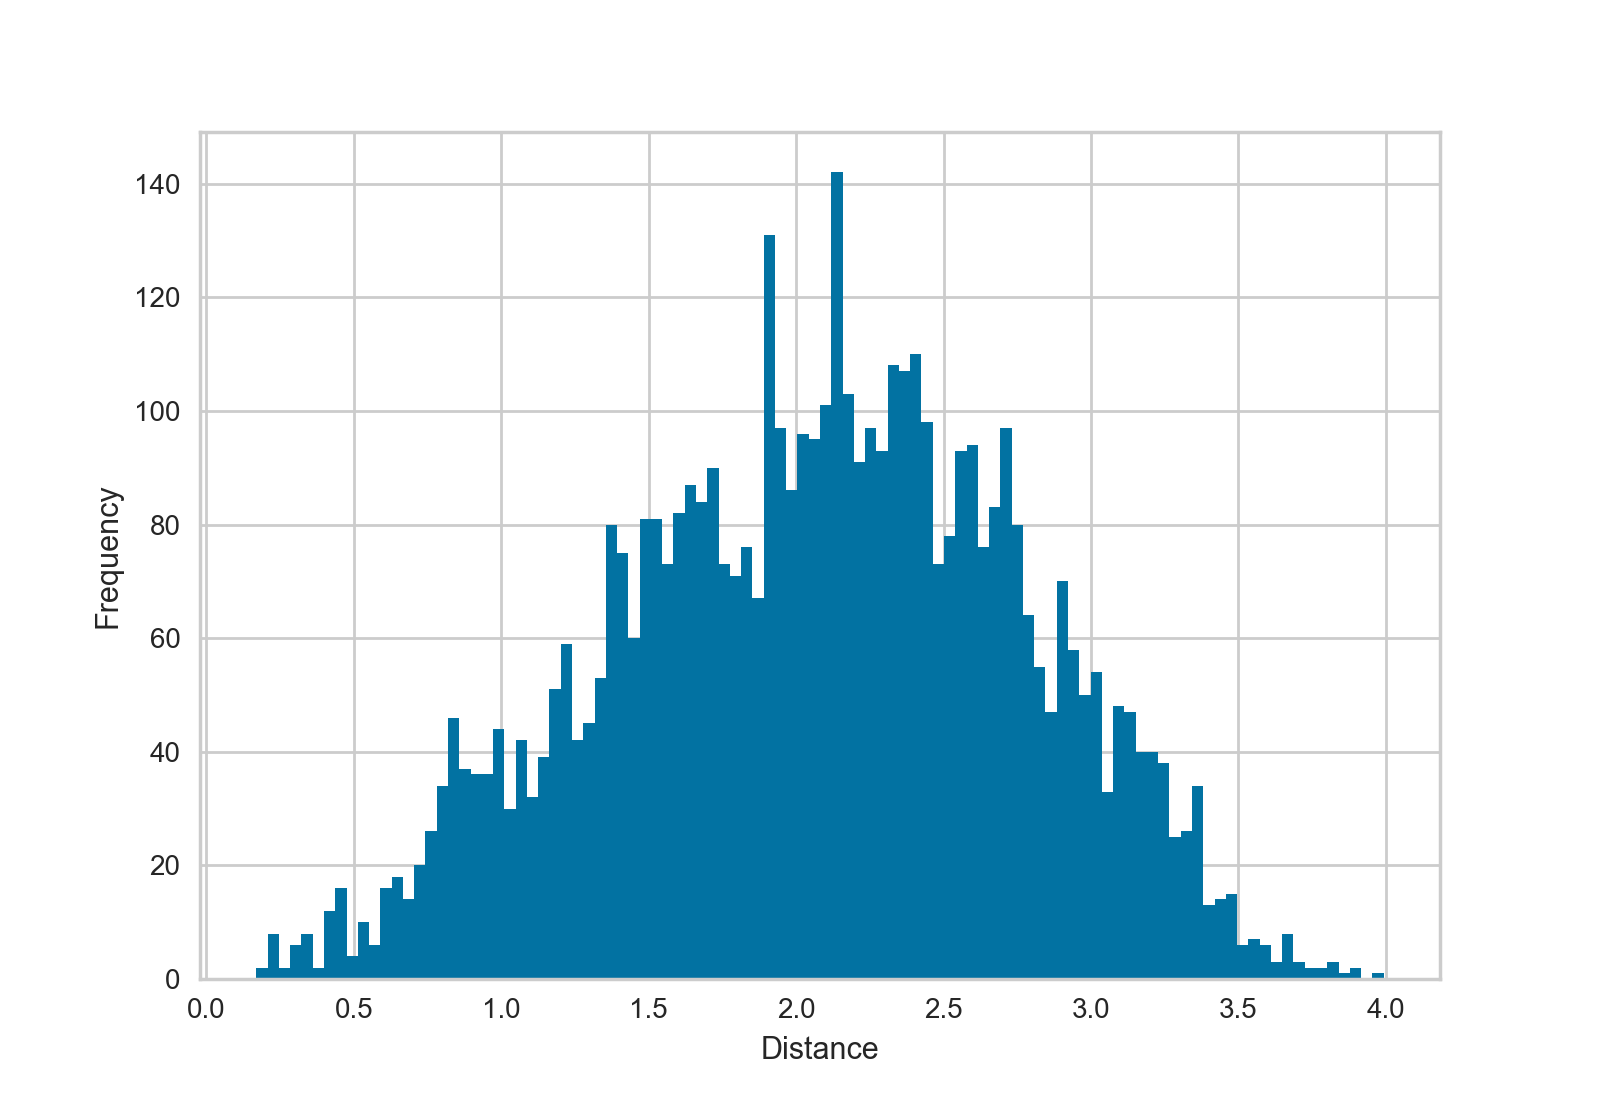

2460
2.0717513273418167


In [8]:
# distance_mds = mds(distance_matrix, 3)

distance_neighbors = get_neighbors(distance_mds, ingredient_list, plot=True)
flat = distance_neighbors[['distance_1','distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7', 'distance_8', 'distance_9', 'distance_10']].values.flatten()
flat = np.sort(flat)
length = int(flat.shape[0] * 0.5)
print(length)
print(flat.mean())






<IPython.core.display.Javascript object>


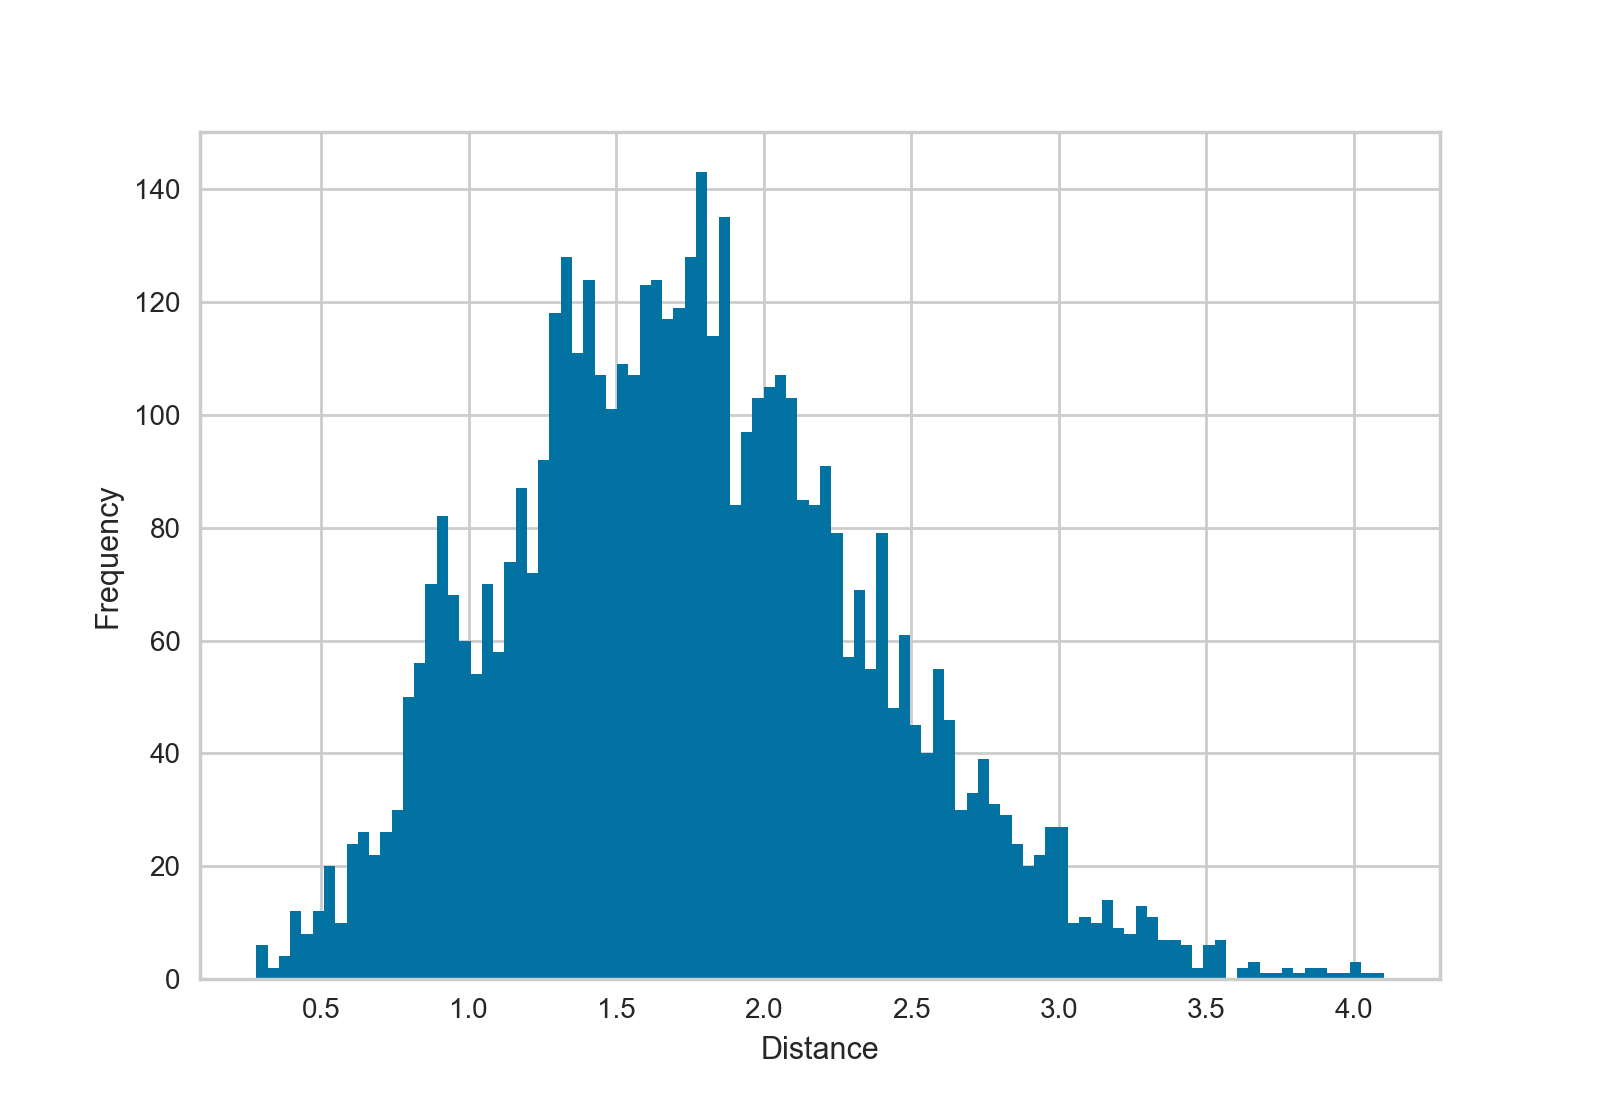

2460
1.759142309339297


In [9]:
pmi_neighbors = get_neighbors(pmi_mds, ingredient_list, plot=True)
flat = pmi_neighbors[['distance_1','distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7', 'distance_8', 'distance_9', 'distance_10']].values.flatten()
flat = np.sort(flat)
length = int(flat.shape[0] * 0.5)
print(length)
print(flat.mean())

<IPython.core.display.Javascript object>


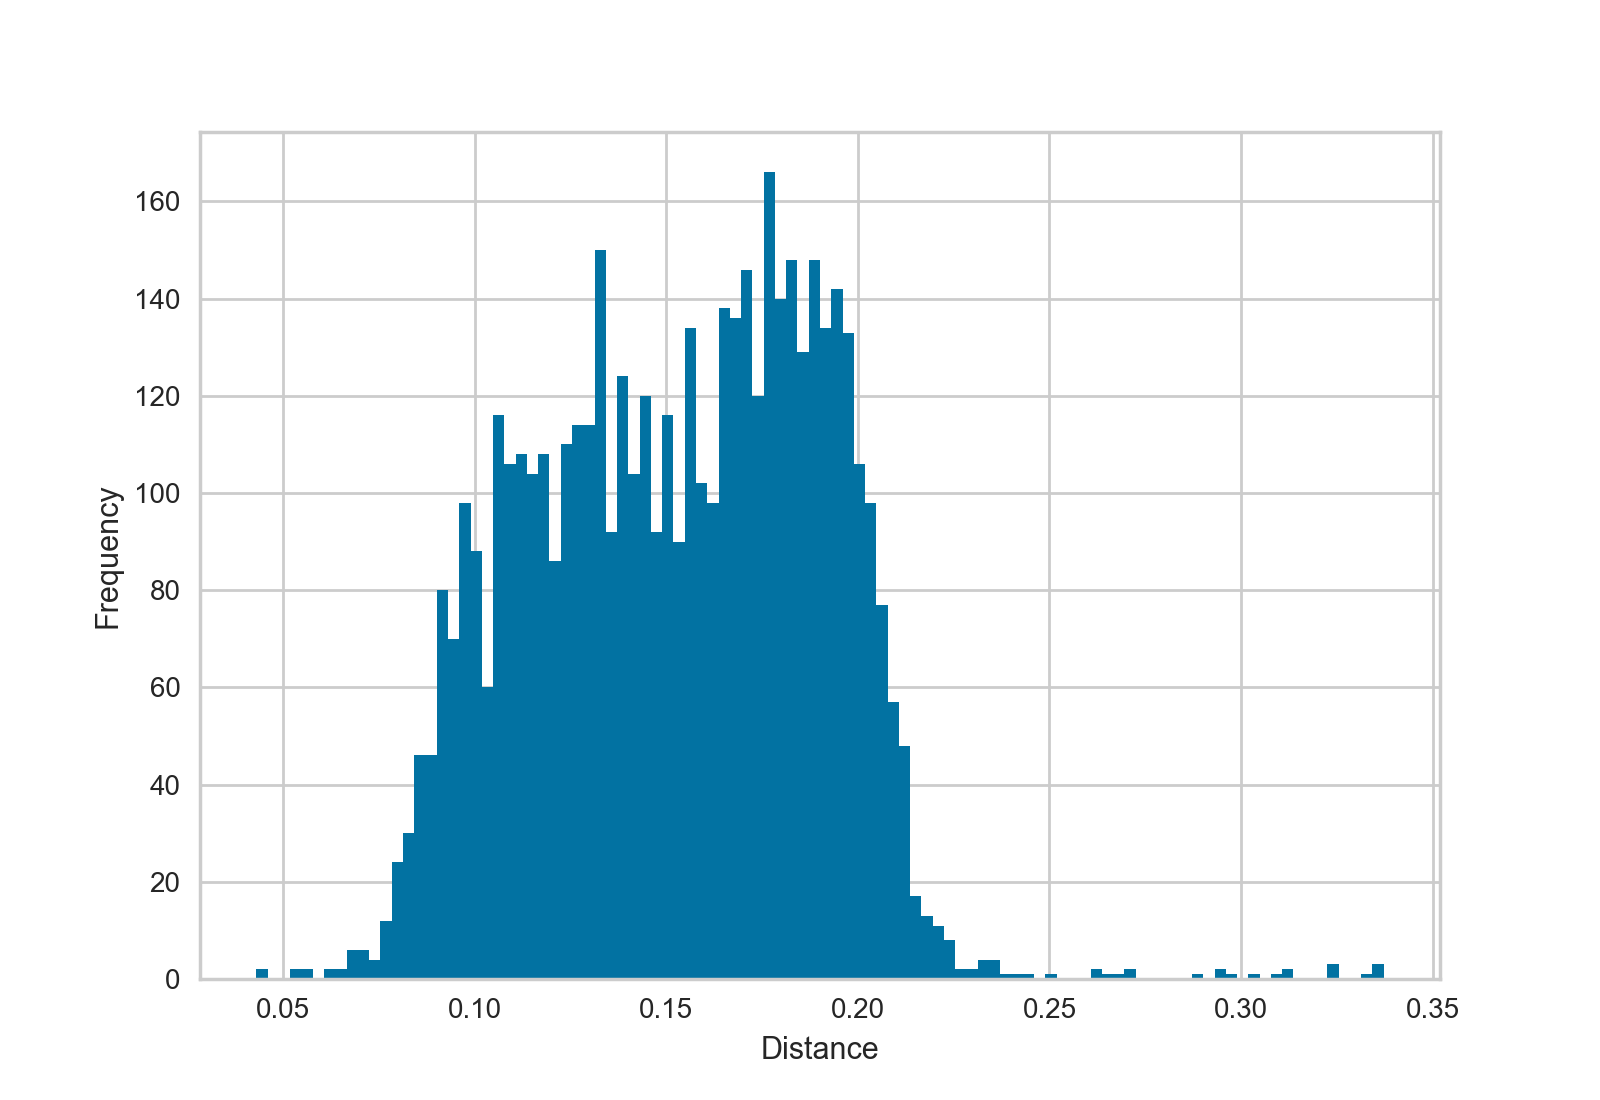

2460
0.1527714110188325


In [10]:
iou_neighbors = get_neighbors(iou_mds, ingredient_list, plot=True)
flat = iou_neighbors[['distance_1','distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6', 'distance_7', 'distance_8', 'distance_9', 'distance_10']].values.flatten()
flat = np.sort(flat)
length = int(flat.shape[0] * 0.5)
print(length)
print(flat.mean())

In [5]:
distance_neighbors = find_pairs(distance_mds, 2.1, edge_matrix, ingredient_list)


distance_neighbors.to_csv('control_group/google/log_comp.csv')


Filtering...


In [6]:
pmi_neighbors = find_pairs(pmi_mds, 2, edge_matrix, ingredient_list)


pmi_neighbors.to_csv('control_group/google/pmi_comp.csv')

Filtering...


In [7]:
iou_neighbors = find_pairs(iou_mds, 0.1, edge_matrix, ingredient_list)


iou_neighbors.to_csv('control_group/google/iou_comp.csv')

Filtering...


In [ ]:
result = one_out('butter', 'flour', recipes.sort_index().T, 250, ingredient_list, mode='LSA')
# distance_mds.shape
# tmp = recipes.sort_index().T.loc[['butter', 'flour'],:]
# print(tmp.sum()==2)
# print(tmp.loc['butter'])
# print(tmp.loc['butter'].mask(tmp.sum()==2, 0))
# print(tmp.sum()==2)

# if any("flour" in s for s in result.loc['butter', :].to_list()[:10]):
#     print('ya')
    
# x = np.array(result.loc['butter', :].to_list()[:10])
# try:
#     y = np.argwhere(x=='egg')[0][0]+1
#     print(result.iloc[:, y+10].name[-1])
# except Exception as e:
#     print('not found')


In [305]:
def merge_lists(df, n_neighbors):
    x_list = []
    y_list = []
    for n in range(1, n_neighbors+1):
        x_list += df.index.tolist()
        y_list += df[f'neighbor_{n}'].tolist()
        
    lists = pd.DataFrame([x_list, y_list]).T
    filter_dups = pd.DataFrame(np.sort(lists[[0,1]], axis=1))
    lists = lists[~filter_dups.duplicated()].reset_index(drop=True)
    return lists[0], lists[1]

# distance_neighbors = get_neighbors(distance_mds, ingredient_list, n_neighbors=3)
# ing_x_list, ing_y_list = merge_lists(distance_neighbors, 3)

# df_distance = one_out_list(ing_x_list, ing_y_list, distance_matrix, 3, ingredient_list)

# pmi_neighbors = get_neighbors(pmi_mds, ingredient_list, n_neighbors=3)
# ing_x_list, ing_y_list = merge_lists(pmi_neighbors, 3)

# df_pmi = one_out_list(ing_x_list, ing_y_list, pmi_matrix, 3, ingredient_list)

# iou_neighbors = get_neighbors(iou_mds, ingredient_list, n_neighbors=3)
# ing_x_list, ing_y_list = merge_lists(iou_neighbors, 3)

# df_iou = one_out_list(ing_x_list, ing_y_list, iou_matrix, 3, ingredient_list)








0it [00:00, ?it/s]






1it [00:34, 34.90s/it]






2it [01:09, 34.85s/it]






3it [01:44, 34.82s/it]






4it [02:19, 34.80s/it]






5it [02:53, 34.74s/it]






6it [03:28, 34.73s/it]






7it [04:03, 34.71s/it]






8it [04:37, 34.68s/it]






9it [05:12, 34.69s/it]






10it [05:47, 34.70s/it]






11it [06:21, 34.71s/it]






12it [06:56, 34.68s/it]






13it [07:31, 34.75s/it]






14it [08:05, 34.69s/it]






15it [08:40, 34.65s/it]






16it [09:15, 34.68s/it]






17it [09:49, 34.64s/it]






18it [10:24, 34.62s/it]






19it [10:59, 34.63s/it]






20it [11:33, 34.65s/it]






21it [12:08, 34.66s/it]






22it [12:43, 34.65s/it]






23it [13:17, 34.66s/it]






24it [13:52, 34.66s/it]






25it [14:27, 34.64s/it]






26it [15:01, 34.66s/it]






27it [15:36, 34.64s/it]






28it [16:10, 34.65s/it]






29it [16:45, 34.70s/it]






30it [17:20, 34.76s/it]






31it [17:55, 34.71s/it]






32it [18:29, 34.69s/it]






33it [19:04, 34.6

308it [2:59:34, 34.29s/it]






309it [3:00:08, 34.27s/it]






310it [3:00:43, 34.24s/it]






311it [3:01:17, 34.26s/it]






312it [3:01:51, 34.30s/it]






313it [3:02:27, 34.60s/it]






314it [3:03:01, 34.57s/it]






315it [3:03:36, 34.56s/it]






316it [3:04:10, 34.53s/it]






317it [3:04:45, 34.51s/it]






318it [3:05:20, 34.70s/it]






319it [3:05:54, 34.61s/it]






320it [3:06:30, 34.94s/it]






321it [3:07:05, 35.04s/it]






322it [3:07:40, 34.89s/it]






323it [3:08:14, 34.74s/it]






324it [3:08:48, 34.61s/it]






325it [3:09:23, 34.54s/it]






326it [3:09:58, 34.66s/it]






327it [3:10:33, 34.76s/it]






328it [3:11:08, 34.89s/it]






329it [3:11:43, 34.98s/it]






330it [3:12:18, 34.96s/it]






331it [3:12:53, 35.03s/it]






332it [3:13:28, 35.10s/it]






333it [3:14:03, 35.06s/it]






334it [3:14:38, 35.03s/it]






335it [3:15:13, 35.08s/it]






336it [3:15:49, 35.10s/it]






337it [3:16:23, 34.98s/it]






338it [3:1

610it [5:57:01, 35.66s/it]






611it [5:57:36, 35.62s/it]






612it [5:58:12, 35.62s/it]






613it [5:58:47, 35.61s/it]






614it [5:59:23, 35.62s/it]






615it [5:59:59, 35.60s/it]






616it [6:00:34, 35.50s/it]






617it [6:01:09, 35.48s/it]






618it [6:01:45, 35.49s/it]






619it [6:02:20, 35.48s/it]






620it [6:02:56, 35.48s/it]






621it [6:03:31, 35.48s/it]






622it [6:04:07, 35.45s/it]






623it [6:04:42, 35.43s/it]






624it [6:05:18, 35.53s/it]






625it [6:05:54, 35.59s/it]






626it [6:06:29, 35.68s/it]






627it [6:07:05, 35.71s/it]






628it [6:07:41, 35.72s/it]






629it [6:08:17, 35.73s/it]






630it [6:08:52, 35.64s/it]






631it [6:09:28, 35.61s/it]






632it [6:10:03, 35.55s/it]






633it [6:10:39, 35.61s/it]






634it [6:11:15, 35.64s/it]






635it [6:11:50, 35.63s/it]






636it [6:12:26, 35.59s/it]






637it [6:13:01, 35.56s/it]






638it [6:13:37, 35.55s/it]






639it [6:14:12, 35.52s/it]






640it [6:1

912it [8:56:18, 35.85s/it]






913it [8:56:53, 35.86s/it]






914it [8:57:29, 35.83s/it]






915it [8:58:05, 35.81s/it]






916it [8:58:41, 35.80s/it]






917it [8:59:17, 35.81s/it]






918it [8:59:52, 35.79s/it]






919it [9:00:28, 35.77s/it]






920it [9:01:04, 35.77s/it]






921it [9:01:40, 35.85s/it]






922it [9:02:16, 35.82s/it]






923it [9:02:51, 35.78s/it]






924it [9:03:27, 35.79s/it]






925it [9:04:03, 35.69s/it]






926it [9:04:38, 35.63s/it]






927it [9:05:14, 35.63s/it]






928it [9:05:49, 35.59s/it]






929it [9:06:25, 35.64s/it]






930it [9:07:01, 35.63s/it]






931it [9:07:36, 35.29s/it]







0it [00:00, ?it/s]






1it [00:19, 19.56s/it]






2it [00:39, 19.55s/it]






3it [00:58, 19.60s/it]






4it [01:19, 20.01s/it]






5it [01:40, 20.24s/it]






6it [02:01, 20.39s/it]






7it [02:21, 20.43s/it]






8it [02:41, 20.12s/it]






9it [03:01, 20.11s/it]






10it [03:21, 20.09s/it]






11it [03:41, 20.18s/it]

139it [47:10, 21.96s/it]






140it [47:32, 22.01s/it]






141it [47:54, 22.04s/it]






142it [48:17, 22.25s/it]






143it [48:40, 22.39s/it]






144it [49:02, 22.39s/it]






145it [49:25, 22.44s/it]






146it [49:47, 22.43s/it]






147it [50:09, 22.31s/it]






148it [50:30, 21.88s/it]






149it [50:51, 21.61s/it]






150it [51:12, 21.42s/it]






151it [51:33, 21.30s/it]






152it [51:54, 21.19s/it]






153it [52:15, 21.12s/it]






154it [52:37, 21.30s/it]






155it [52:58, 21.37s/it]






156it [53:19, 21.33s/it]






157it [53:41, 21.52s/it]






158it [54:03, 21.44s/it]






159it [54:24, 21.40s/it]






160it [54:46, 21.69s/it]






161it [55:09, 21.87s/it]






162it [55:31, 22.02s/it]






163it [55:53, 22.11s/it]






164it [56:16, 22.18s/it]






165it [56:38, 22.25s/it]






166it [57:01, 22.34s/it]






167it [57:22, 22.07s/it]






168it [57:43, 21.82s/it]






169it [58:04, 21.60s/it]






170it [58:26, 21.48s/it]






171it [5

443it [2:40:29, 22.43s/it]






444it [2:40:51, 22.47s/it]






445it [2:41:14, 22.52s/it]






446it [2:41:36, 22.41s/it]






447it [2:41:59, 22.42s/it]






448it [2:42:21, 22.42s/it]






449it [2:42:43, 22.37s/it]






450it [2:43:06, 22.36s/it]






451it [2:43:28, 22.38s/it]






452it [2:43:51, 22.49s/it]






453it [2:44:13, 22.53s/it]






454it [2:44:37, 22.80s/it]






455it [2:44:59, 22.73s/it]






456it [2:45:22, 22.69s/it]






457it [2:45:45, 22.64s/it]






458it [2:46:07, 22.57s/it]






459it [2:46:29, 22.40s/it]






460it [2:46:51, 22.31s/it]






461it [2:47:13, 22.24s/it]






462it [2:47:35, 22.21s/it]






463it [2:47:57, 22.13s/it]






464it [2:48:19, 22.09s/it]






465it [2:48:41, 22.06s/it]






466it [2:49:04, 22.12s/it]






467it [2:49:26, 22.22s/it]






468it [2:49:48, 22.24s/it]






469it [2:50:10, 22.14s/it]






470it [2:50:32, 22.15s/it]






471it [2:50:55, 22.18s/it]






472it [2:51:17, 22.18s/it]






473it [2:5

745it [4:52:37, 25.38s/it]






746it [4:53:04, 26.02s/it]






747it [4:53:28, 25.37s/it]






748it [4:53:53, 25.43s/it]






749it [4:54:17, 24.97s/it]






750it [4:54:42, 24.82s/it]






751it [4:55:05, 24.43s/it]






752it [4:55:32, 25.00s/it]






753it [4:55:58, 25.42s/it]






754it [4:56:22, 24.84s/it]






755it [4:56:45, 24.31s/it]






756it [4:57:09, 24.46s/it]






757it [4:57:33, 24.17s/it]






758it [4:57:57, 24.09s/it]






759it [4:58:21, 24.04s/it]






760it [4:58:45, 24.02s/it]






761it [4:59:09, 24.00s/it]






762it [4:59:33, 23.97s/it]






763it [4:59:57, 23.98s/it]






764it [5:00:21, 24.15s/it]






765it [5:00:46, 24.23s/it]






766it [5:01:09, 24.10s/it]






767it [5:01:33, 23.98s/it]






768it [5:01:57, 23.92s/it]






769it [5:02:21, 24.11s/it]






770it [5:02:45, 23.87s/it]






771it [5:03:08, 23.66s/it]






772it [5:03:32, 23.88s/it]






773it [5:03:56, 23.69s/it]






774it [5:04:20, 24.06s/it]






775it [5:0

111it [01:36,  1.29it/s]






112it [01:37,  1.28it/s]






113it [01:38,  1.29it/s]






114it [01:39,  1.30it/s]






115it [01:39,  1.29it/s]






116it [01:40,  1.31it/s]






117it [01:41,  1.29it/s]






118it [01:42,  1.28it/s]






119it [01:42,  1.28it/s]






120it [01:43,  1.28it/s]






121it [01:44,  1.23it/s]






122it [01:45,  1.18it/s]






123it [01:46,  1.11it/s]






124it [01:47,  1.07it/s]






125it [01:48,  1.04it/s]






126it [01:49,  1.06it/s]






127it [01:50,  1.06it/s]






128it [01:51,  1.08it/s]






129it [01:52,  1.07it/s]






130it [01:53,  1.09it/s]






131it [01:54,  1.02it/s]






132it [01:55,  1.02it/s]






133it [01:56,  1.08it/s]






134it [01:56,  1.14it/s]






135it [01:57,  1.19it/s]






136it [01:58,  1.22it/s]






137it [01:59,  1.28it/s]






138it [01:59,  1.26it/s]






139it [02:00,  1.32it/s]






140it [02:01,  1.37it/s]






141it [02:01,  1.41it/s]






142it [02:02,  1.44it/s]






143it [0

425it [05:41,  1.47it/s]






426it [05:41,  1.47it/s]






427it [05:42,  1.47it/s]






428it [05:43,  1.47it/s]






429it [05:43,  1.47it/s]






430it [05:44,  1.48it/s]






431it [05:45,  1.48it/s]






432it [05:45,  1.48it/s]






433it [05:46,  1.48it/s]






434it [05:47,  1.48it/s]






435it [05:47,  1.48it/s]






436it [05:48,  1.48it/s]






437it [05:49,  1.48it/s]






438it [05:49,  1.48it/s]






439it [05:50,  1.48it/s]






440it [05:51,  1.48it/s]






441it [05:51,  1.49it/s]






442it [05:52,  1.50it/s]






443it [05:53,  1.50it/s]






444it [05:53,  1.50it/s]






445it [05:54,  1.50it/s]






446it [05:55,  1.50it/s]






447it [05:55,  1.49it/s]






448it [05:56,  1.48it/s]






449it [05:57,  1.48it/s]






450it [05:57,  1.48it/s]






451it [05:58,  1.48it/s]






452it [05:59,  1.48it/s]






453it [06:00,  1.48it/s]






454it [06:00,  1.48it/s]






455it [06:01,  1.48it/s]






456it [06:02,  1.48it/s]






457it [0

739it [09:22,  1.55it/s]






740it [09:22,  1.55it/s]






741it [09:23,  1.55it/s]






742it [09:24,  1.55it/s]






743it [09:24,  1.55it/s]






744it [09:25,  1.55it/s]






745it [09:25,  1.55it/s]






746it [09:26,  1.55it/s]






747it [09:27,  1.54it/s]






748it [09:27,  1.55it/s]






749it [09:28,  1.54it/s]






750it [09:29,  1.54it/s]






751it [09:29,  1.55it/s]






752it [09:30,  1.54it/s]






753it [09:31,  1.54it/s]






754it [09:31,  1.54it/s]






755it [09:32,  1.53it/s]






756it [09:33,  1.50it/s]






757it [09:33,  1.48it/s]






758it [09:34,  1.49it/s]






759it [09:35,  1.50it/s]






760it [09:35,  1.51it/s]






761it [09:36,  1.51it/s]






762it [09:37,  1.51it/s]






763it [09:37,  1.52it/s]






764it [09:38,  1.52it/s]






765it [09:39,  1.52it/s]






766it [09:39,  1.50it/s]






767it [09:40,  1.48it/s]






768it [09:41,  1.46it/s]






769it [09:41,  1.44it/s]






770it [09:42,  1.46it/s]






771it [0

In [9]:
df_distance.groupby('og_neighbor')['neighbor'].value_counts()
# df_distance.to_csv('dataset/one_out/log_distance.csv')

NameError: name 'df_distance' is not defined

In [ ]:
df_pmi.groupby('og_neighbor')['neighbor'].value_counts()
# df_pmi.to_csv('dataset/one_out/pmi.csv')

In [317]:
df_iou.groupby('og_neighbor')['neighbor'].value_counts()
# df_iou.to_csv('dataset/one_out/iou.csv')

### Max Dist

In [20]:
from scipy.spatial.distance import squareform, pdist

pmi_distances = pd.DataFrame(squareform(pdist(pmi_mds.iloc[:, 1:])), columns=pmi_mds.index, index=pmi_mds.index)

pmi_max = pmi_distances.idxmax()

pmi_max

acorn squash                  broccoli rabe
active dry yeast                 fish stock
agave nectar                  broccoli rabe
allspice                      broccoli rabe
almond butter                 broccoli rabe
almond extract                    rice wine
almond flour                  broccoli rabe
almond milk                   broccoli rabe
almond paste                      rice wine
almonds                               squid
amaretto liqueur                  rice wine
ameri cheese                          squid
anchovy                           rye flour
anchovy paste                  wheat gluten
angel hair pasta               wheat gluten
angostura bitters              wheat gluten
apple                             rice wine
apple cider vinegar      chocolate cake mix
apple juice                       rice wine
apple sauce                      fish stock
apricot                       broccoli rabe
apricot jam                       rice wine
arborio rice                   w

In [21]:
log_distances = pd.DataFrame(squareform(pdist(distance_mds.iloc[:, 1:])), columns=pmi_mds.index, index=pmi_mds.index)

log_max = log_distances.idxmax()

log_max


acorn squash                         rice wine
active dry yeast                     rice wine
agave nectar             creamy salad dressing
allspice                         refried beans
almond butter                        rice wine
almond extract              kaffir lime leaves
almond flour                         rice wine
almond milk                          rice wine
almond paste                     broccoli rabe
almonds                              rice wine
amaretto liqueur                 broccoli rabe
ameri cheese                           madeira
anchovy                          refried beans
anchovy paste                    refried beans
angel hair pasta                 broccoli rabe
angostura bitters                broccoli rabe
apple                                rice wine
apple cider vinegar       cream of celery soup
apple juice                      refried beans
apple sauce                 kaffir lime leaves
apricot                          refried beans
apricot jam  

# Regression

In [162]:
# plt.figure()

# plt.hist(ratings['review_count'][ratings['review_count']>5], bins=1000)
# plt.xlabel('Rating')
# plt.ylabel('Frequency')
# plt.show()

print(ratings['review_count'][ratings['review_count']>5].describe())
print(ratings['review_count'].describe())

count    70260.000000
mean        66.039582
std        231.999950
min          6.000000
25%         11.000000
50%         21.000000
75%         50.000000
max      10673.000000
Name: review_count, dtype: float64
count    102430.000000
mean         46.144665
std         194.382329
min           1.000000
25%           4.000000
50%          11.000000
75%          32.000000
max       10673.000000
Name: review_count, dtype: float64


<IPython.core.display.Javascript object>


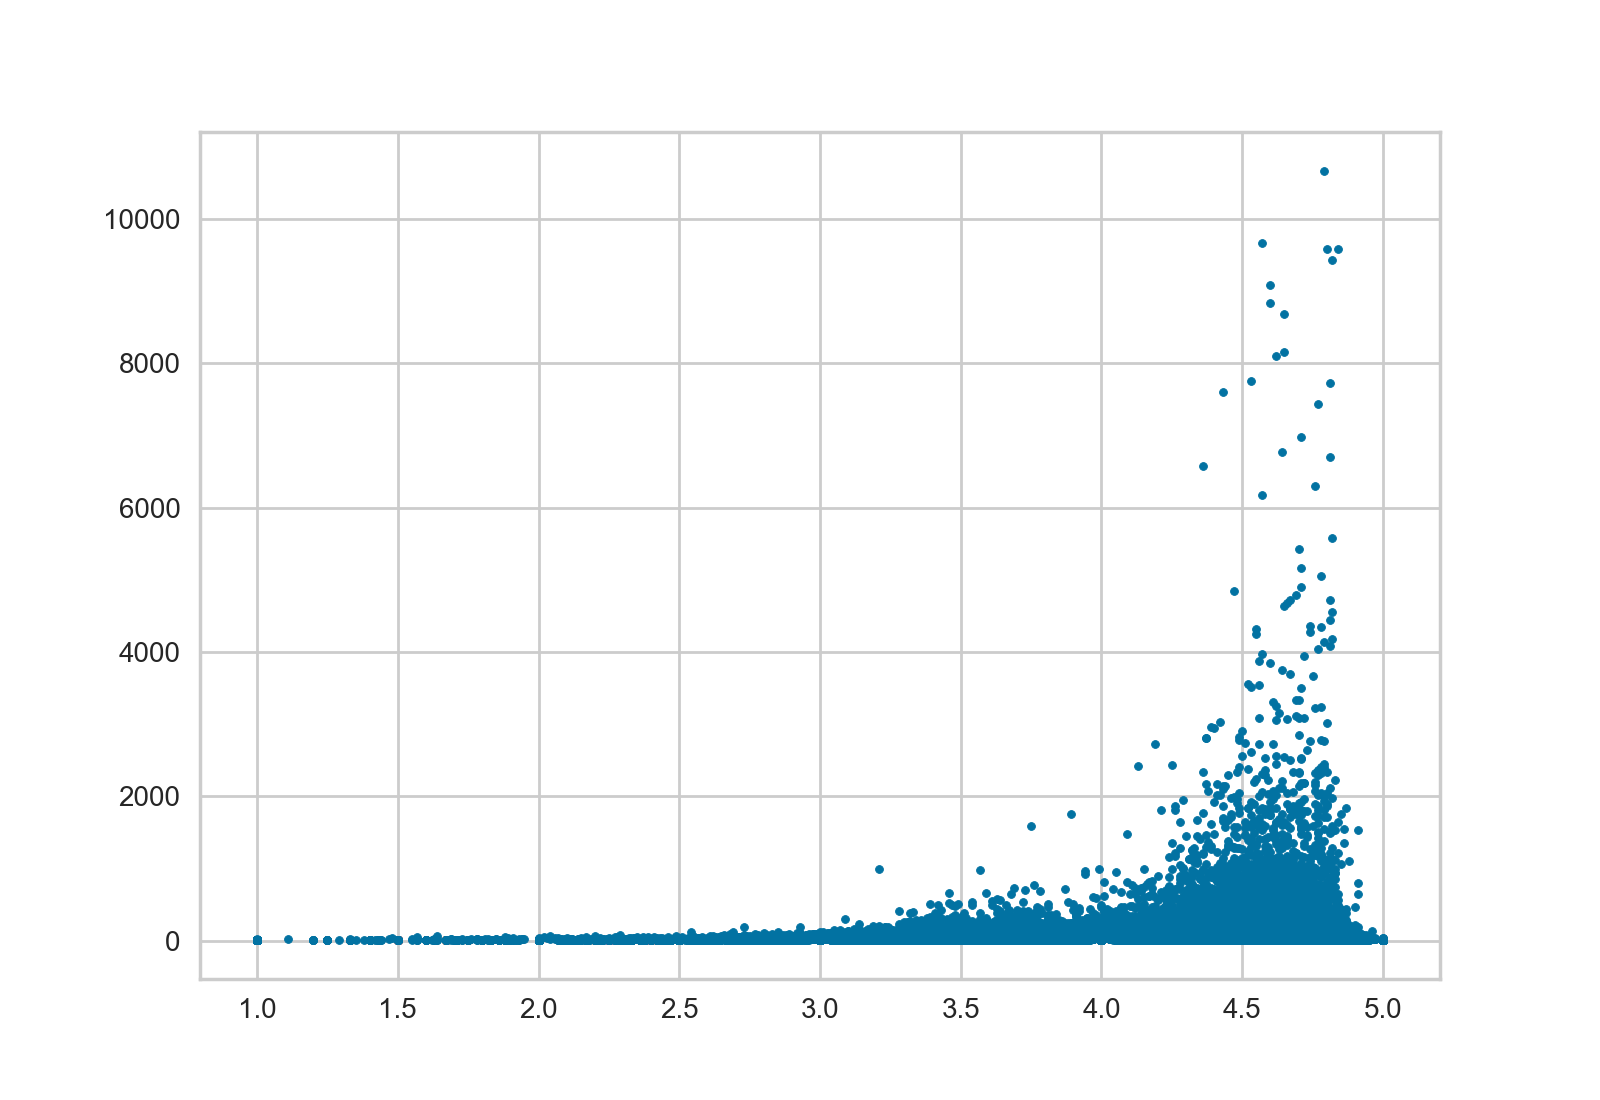

In [157]:
plt.figure()
plt.scatter(ratings['rating'], ratings['review_count'], s=8)
plt.show()

(93767,)
(93767, 492)
(93767, 1)


0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


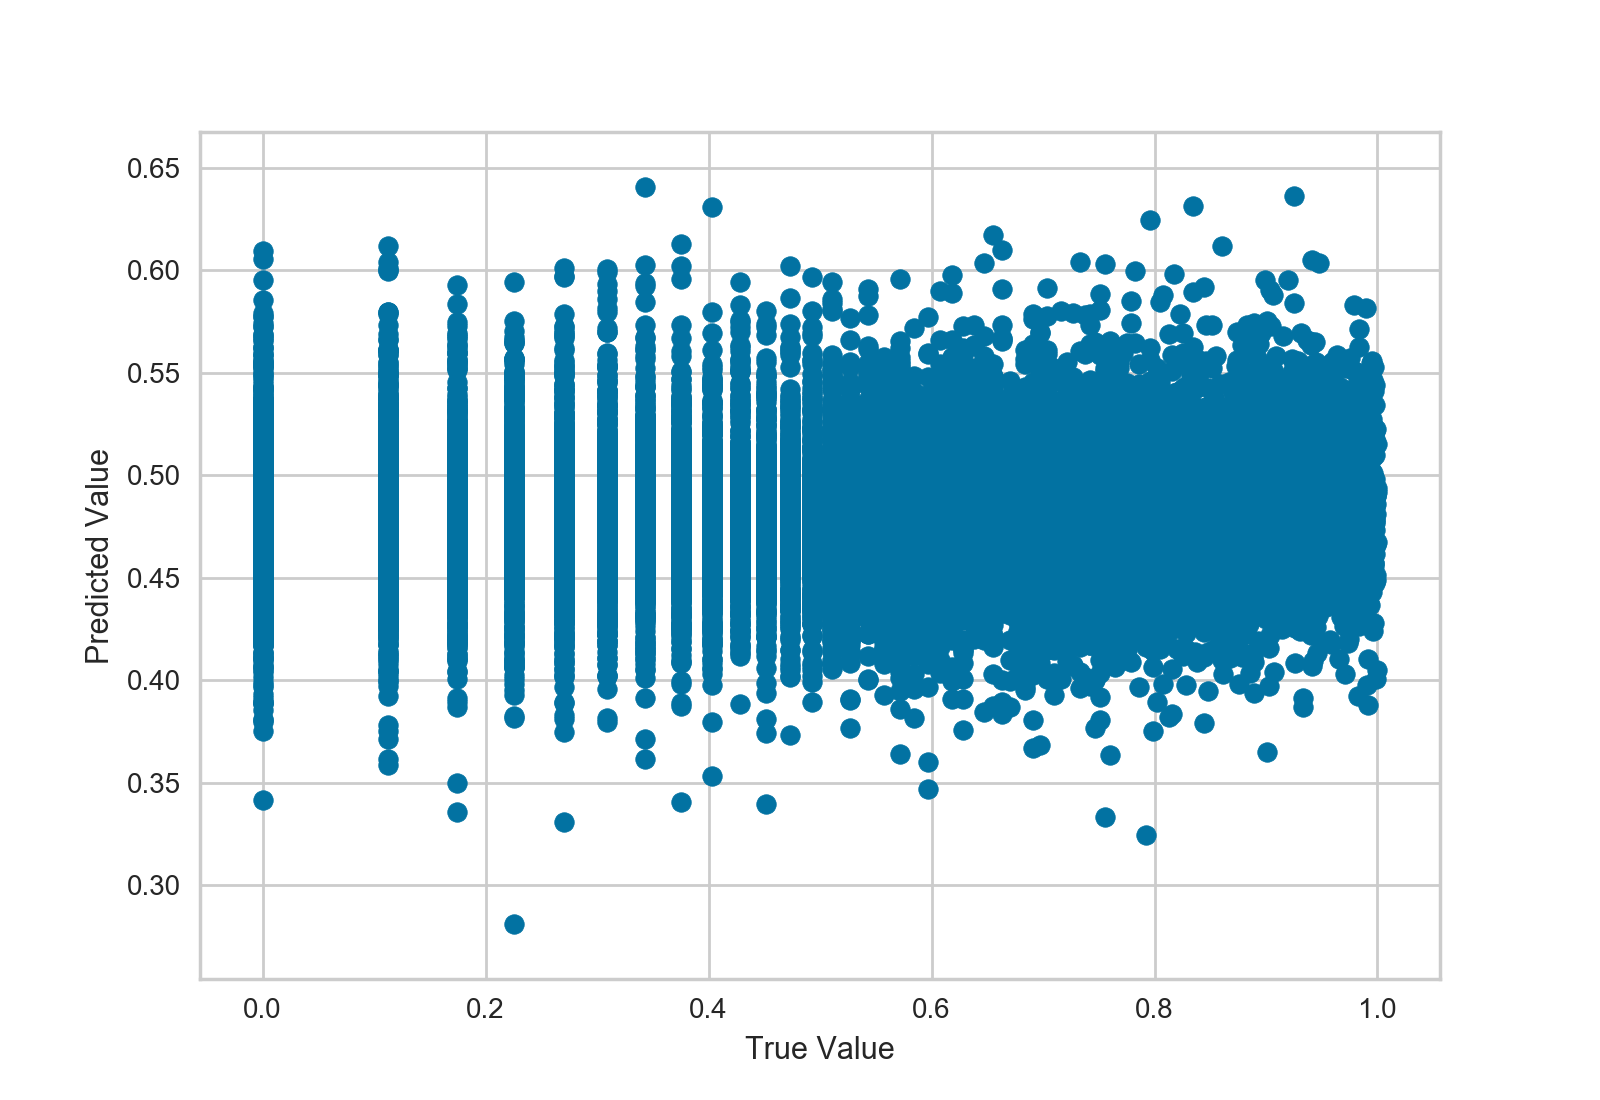

1it [00:03,  3.12s/it]/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


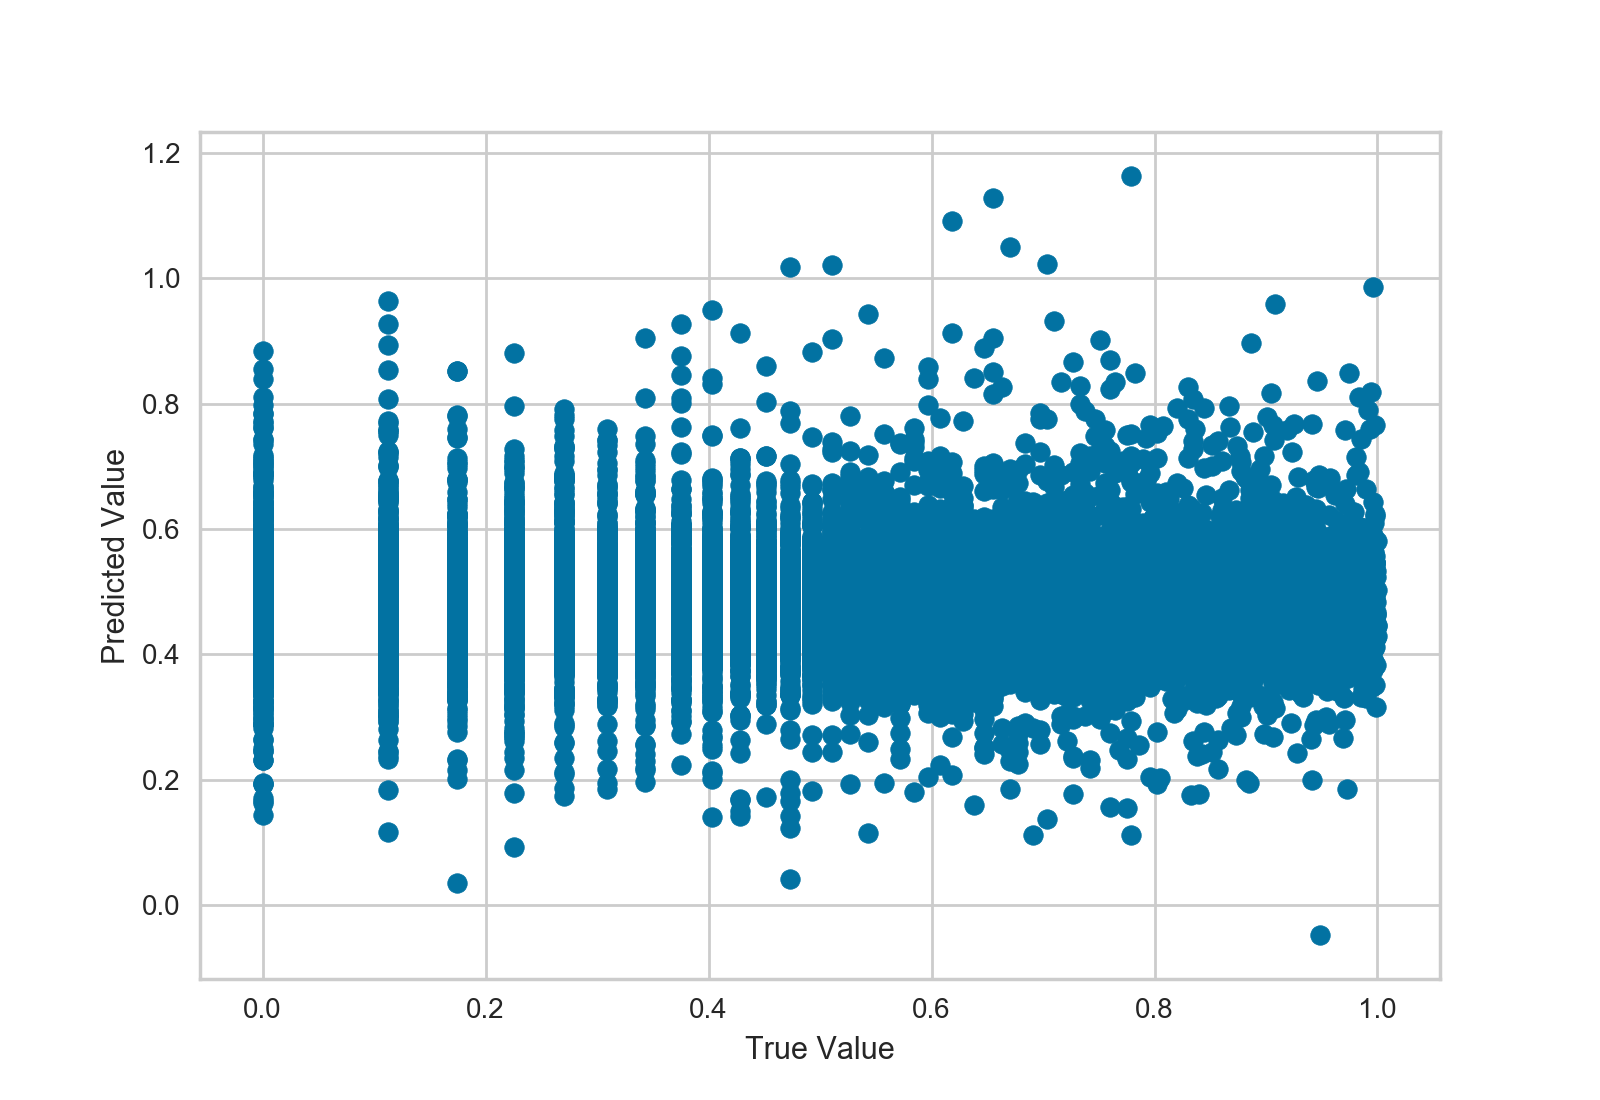

2it [00:16,  8.30s/it]

╒════════╤══════════╤══════════╕
│ Data   │        0 │        1 │
╞════════╪══════════╪══════════╡
│ Min    │        0 │        0 │
├────────┼──────────┼──────────┤
│ Max    │ 0.999868 │ 0.999868 │
├────────┼──────────┼──────────┤
│ MSE    │  0.07959 │  0.08403 │
├────────┼──────────┼──────────┤
│ MAE    │  0.24083 │  0.24534 │
├────────┼──────────┼──────────┤
│ R2     │   0.0003 │ -0.05553 │
╘════════╧══════════╧══════════╛


In [136]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, BayesianRidge, HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import robust_scale, QuantileTransformer, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import euclidean_distances

rated_recipes = recipes[recipes.index.isin(ratings.index)]

X = rated_recipes.sort_index()



y = ratings['review_count'][ratings['review_count']>1].sort_index()

print(y.shape)
source = 'allrecipes'
# source = 'cookstr'
source2 = 'recipes/food'

# print(X.shape)
# print(y.shape)
# print()
# X_onesource = X[X.index.str.contains(source)]
y_onesource = y[y.index.str.contains(source)]
y_onesource2 = y[y.index.str.contains(source2)]

# print(y.describe())
# print(y_onesource.describe())
# print(y_onesource2.describe())

qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')
ar = pd.DataFrame(qt.fit_transform(y_onesource.values.reshape(-1, 1)))
ar.index = y_onesource.index
ec = pd.DataFrame(qt.transform(y_onesource2.values.reshape(-1, 1)))
ec.index = y_onesource2.index
review_count_qt = pd.concat([ar, ec])


# ar = y_onesource/y_onesource.sum()
# ar.index = y_onesource.index
# ec = y_onesource2/y_onesource2.sum()
# ec.index = y_onesource2.index

# review_count_sum = pd.concat([ar, ec])*10000
# review_count_sum.name = 'review_count_sum'


fn_to_name = {SVR : 'SVR',
            LinearRegression: 'L-Regression', 
            Ridge : 'Ridge',
            RidgeCV : 'RidgeCV',
            BayesianRidge: 'B-Ridge',
            Lasso : 'Lasso',
            HuberRegressor : 'H-Regressor',
            MLPRegressor: 'MLP'
            }


regr_stats = { 'Data' : ['Min', 'Max', 'MSE', 'MAE', 'R2']}
top_coefs = {}


scaler = MinMaxScaler()
y = review_count_qt
# y = review_count_sum
# y = pd.DataFrame(scaler.fit_transform(ratings['rating'][ratings['review_count']>6].values.reshape(-1, 1)))
y.index = ratings[ratings['review_count']>1].index
y.sort_index()

# X = calc_distances(y.shape[0], recipes[recipes.index.isin(y.index)], distance_mds, euclidean_distances)

X = X[X.index.isin(y.index)]

# y = y[y.index.isin(X.index)]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

models = [LinearRegression(), MLPRegressor((10,20,10))]

# models = [HuberRegressor(epsilon=1.05), 
#           HuberRegressor(epsilon=1.15), 
#           HuberRegressor(epsilon=1.25), 
#           HuberRegressor(epsilon=1.35),
#           HuberRegressor(epsilon=1.45),
#          HuberRegressor(epsilon=1.55),
#          HuberRegressor(epsilon=1.65)] 
# models = [MLPRegressor((20,50,20)),
#          MLPRegressor((10,20,10)),
#          MLPRegressor((100,200,100)),
#          MLPRegressor((300, 500, 100, 10)),
#          MLPRegressor((200, 50, 10)),
#          MLPRegressor((100, 20)),
#          MLPRegressor((50, 100, 50))]
# plt.figure()
for idx, model in tqdm(enumerate(models)):

    reg = model

    reg = reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    minimum = y_test.min()
    maximum = y_test.max()
    mse = round(mean_squared_error(y_test, y_pred),5)
    mae = round(mean_absolute_error(y_test, y_pred),5)
    r2 = round(r2_score(y_test, y_pred),5)
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')

    ## Test ys
#         plt.subplot(len(ys),1,idx+1)
# #         plt.bar(range(reg.coef_.shape[0]), reg.coef_)
#         plt.scatter(y_test, y_pred)
# #         top_coefs[f'{y.name}_max'] = np.argsort(reg.coef_)[:10]
# #         top_coefs[f'{y.name}_min'] = np.argsort(-reg.coef_)[:10]
#         regr_stats[y.name] = [minimum, maximum, mse, mae, r2]
    ## Test Models
#     if model != RANSACRegressor:
#         top_coefs[f'{fn_to_name[model]}_max'] = np.argsort(reg.coef_)[:10]
#         top_coefs[f'{fn_to_name[model]}_min'] = np.argsort(-reg.coef_)[:10]
    regr_stats[idx] = [minimum, maximum, mse, mae, r2]
    
print(tabulate(regr_stats, headers='keys', tablefmt='fancy_grid', numalign="right"))
top_coefs = {k: ingredient_list[v] for k, v in top_coefs.items()}
plt.show()

In [272]:
# X_mds = X
# X = X_mds
X = rated_recipes.sort_index()

In [273]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [274]:
rated_recipes_count = rated_recipes.sum(axis=1)

# X = X_mds_euc
# X = X[X['mean_dist']>0]
# X['count'] = rated_recipes_count[rated_recipes_count.index.isin(X.index)].sort_index()
# X.sort_index()

<IPython.core.display.Javascript object>


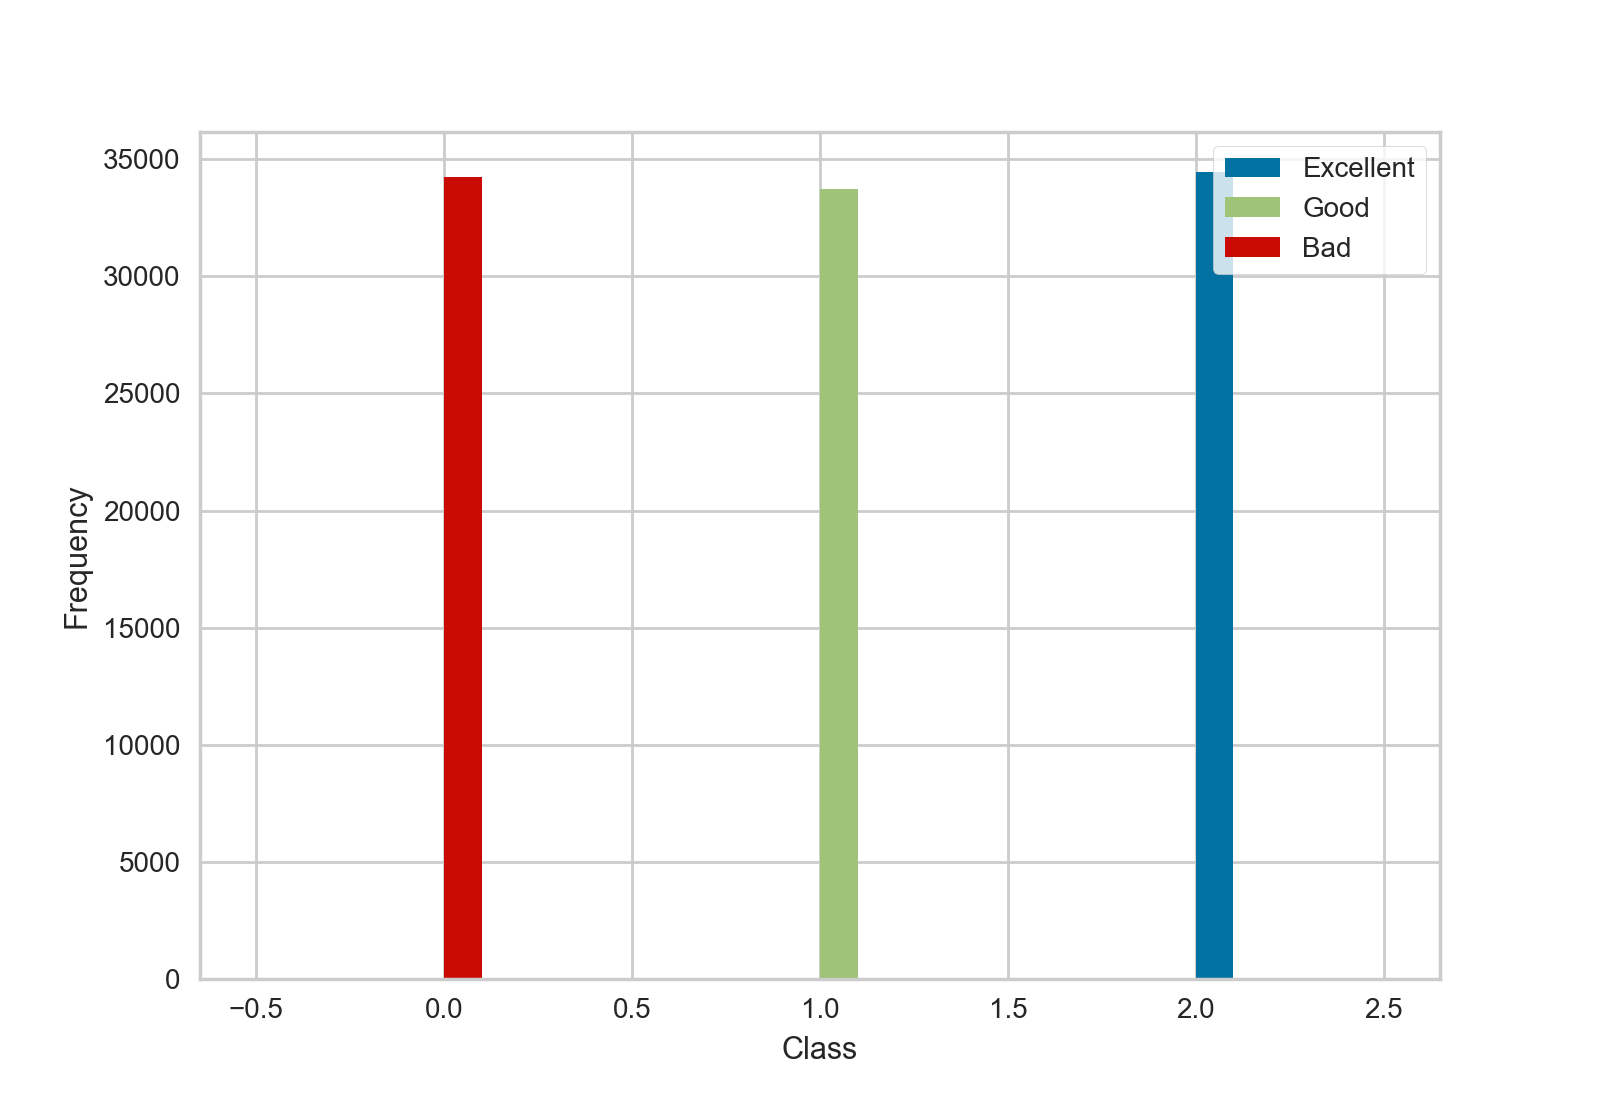

In [275]:
from keras.utils import to_categorical

ratings['class'] = ratings['rating'].mask(ratings['rating'] > 0, 2)   # rating > 4.4
ratings['class'] = ratings['class'].mask(ratings['rating'] <= 4.4, 1)    # 3.7 < rating <= 4.4
ratings['class'] = ratings['class'].mask(ratings['rating'] <= 3.7, 0)    # rating <= 3.7

tmp = ratings['class'][ratings['class'].index.isin(X.index)]
tmp.sort_index()

y = to_categorical(tmp)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

plt.figure()
plt.hist(ratings['class'][ratings['class']==2], label='Excellent')
plt.hist(ratings['class'][ratings['class']==1], label='Good')
plt.hist(ratings['class'][ratings['class']==0], label='Bad')
plt.legend(loc='upper right', frameon=True)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [137]:
activ_fn = 'relu'
kernel_init = 'glorot_uniform'

loss_fn = 'categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(
                                    learning_rate=0.00001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    amsgrad=False
                                )
dropout_rate = 0.5
l2_reg = 0.01

def neural_net(reg_val=l2_reg, drop=dropout_rate, loss=loss_fn, optim=optimizer):
    model = Sequential()
#     model.add( Dense(30, input_dim=(3), activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
#     model.add( Dense(500, activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
#     model.add( Dense(200, activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
#     model.add( Dropout(drop, seed=RANDOM_SEED) )
    model.add( Dense(100, input_dim=(492), activation=activ_fn, kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    model.add( Dense(20, activation=activ_fn, kernel_initializer=kernel_init) )
    model.add( Dense(10, activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dense(60, activation=activ_fn, kernel_initializer=kernel_init) )
#     model.add( Dense(10, activation=activ_fn, kernel_initializer=kernel_init) )
    model.add( Dense(3, activation='softmax', kernel_initializer=kernel_init, kernel_regularizer=l2(reg_val)) )
    
    model.compile(loss=loss_fn, optimizer=optim)
    return model

model = neural_net()

NameError: name 'tf' is not defined

In [138]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
train_log = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.2, verbose=1, callbacks=[early_stopping])

NameError: name 'EarlyStopping' is not defined

<IPython.core.display.Javascript object>


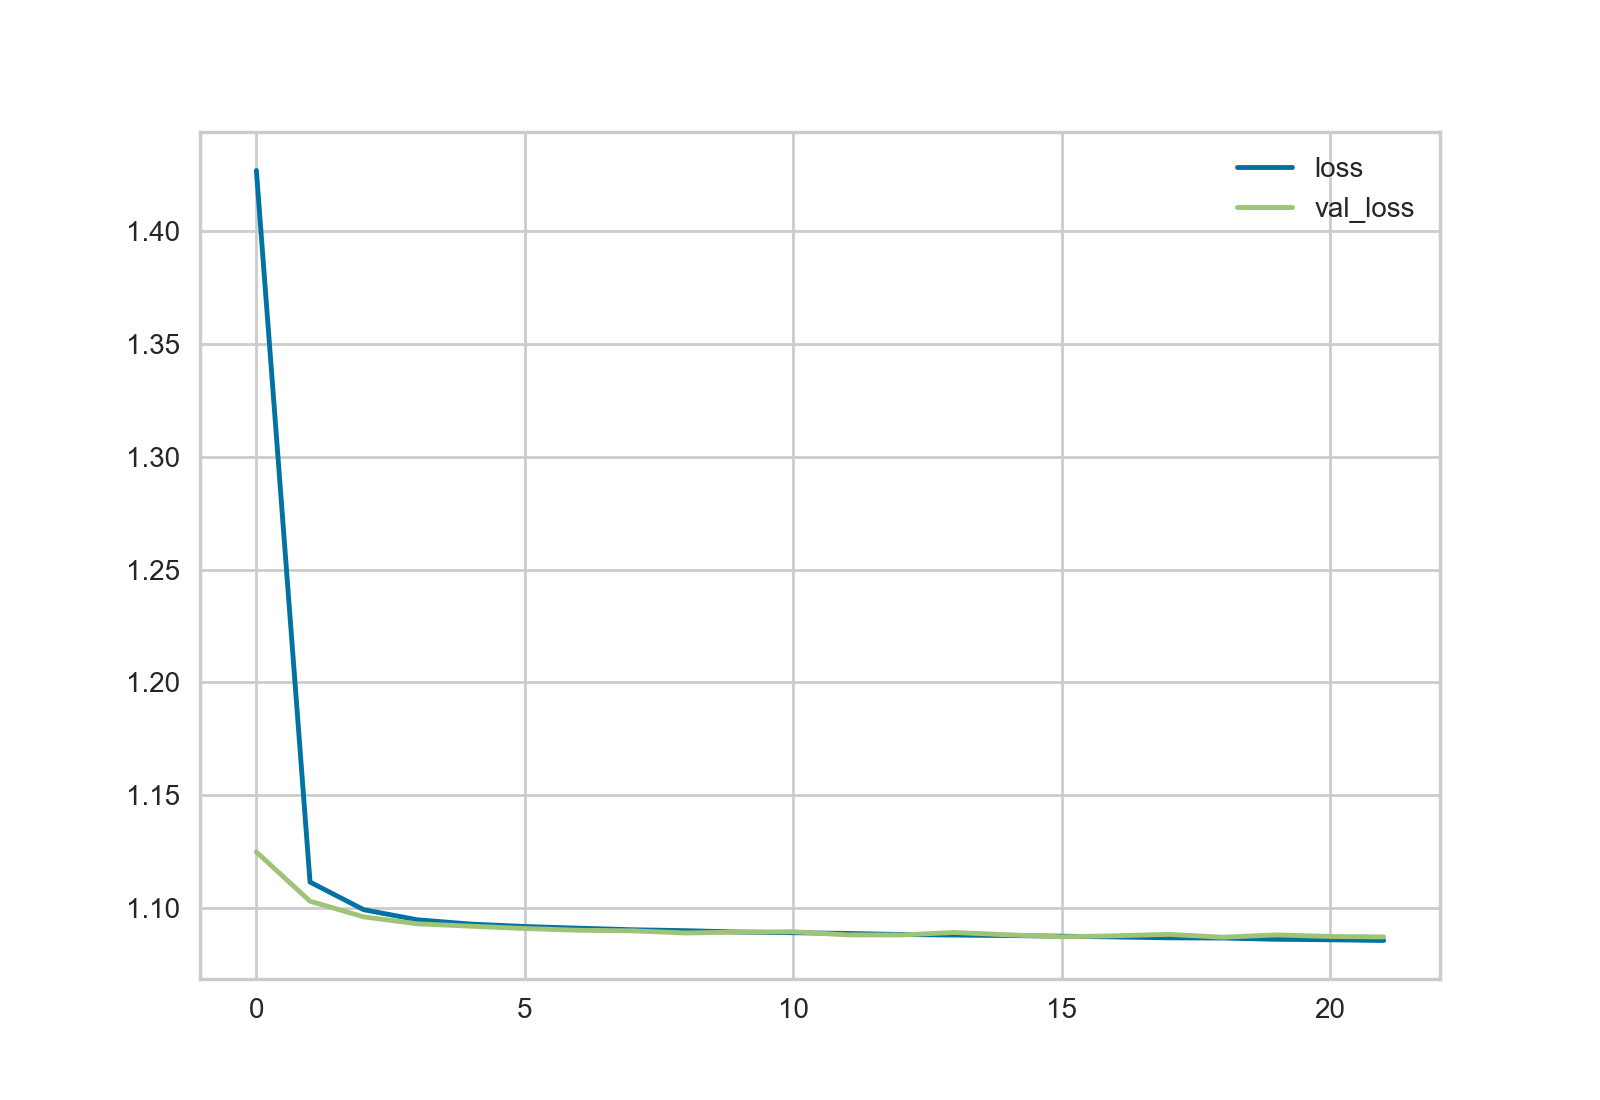

In [283]:
plt.figure()
plt.plot(train_log.history["loss"], label="loss")
plt.plot(train_log.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [148]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# y_pred = pd.Series(y_pred).argmax()
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Model test MSE : {mse}')
# print(f'Model test MAE : {mae}')
# print(f'Model test R2 : {r2}')
# print(classification_report(np.array(y_test).argmax(axis=-1), y_pred))
# print(np.array(y_test).argmax(axis=-1))
print(y_pred.shape)

(18754,)


<IPython.core.display.Javascript object>


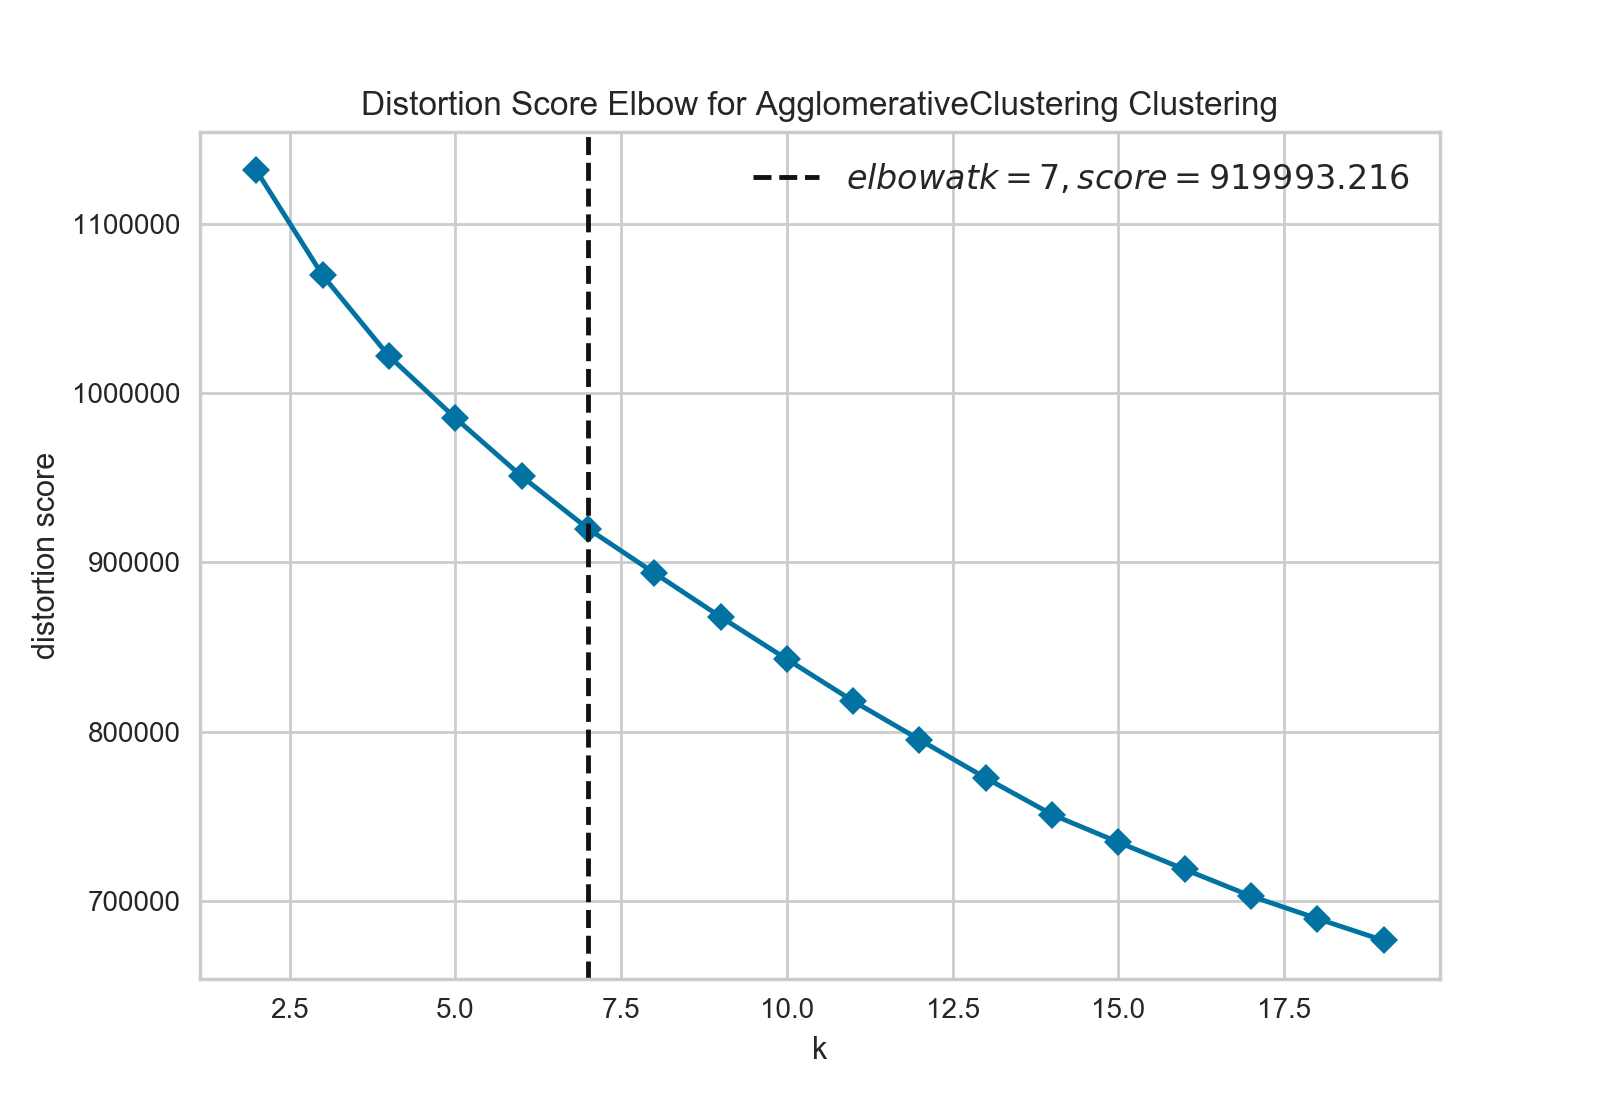

In [26]:
model = AgglomerativeClustering()

visualizer = KElbowVisualizer(model, k=(2,20), timings=False)

X = lsa_out_df
# X = distance_mds
# X = pmi_mds
# X = iou_mds


visualizer.fit(X)
# visualizer.set_xlabel('Number of Clusters')
visualizer.show()